#Fazendo as importações necessárias

In [333]:
!pip install -q gdown
!pip install -q duckdb
import gdown
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Feitas as importações, vamos começar analisando os dados do CadÚnico, disponibilizados pelo Ministério do Desenvolvimento e Assitência Social, Família e Combate à Fome (MDS).

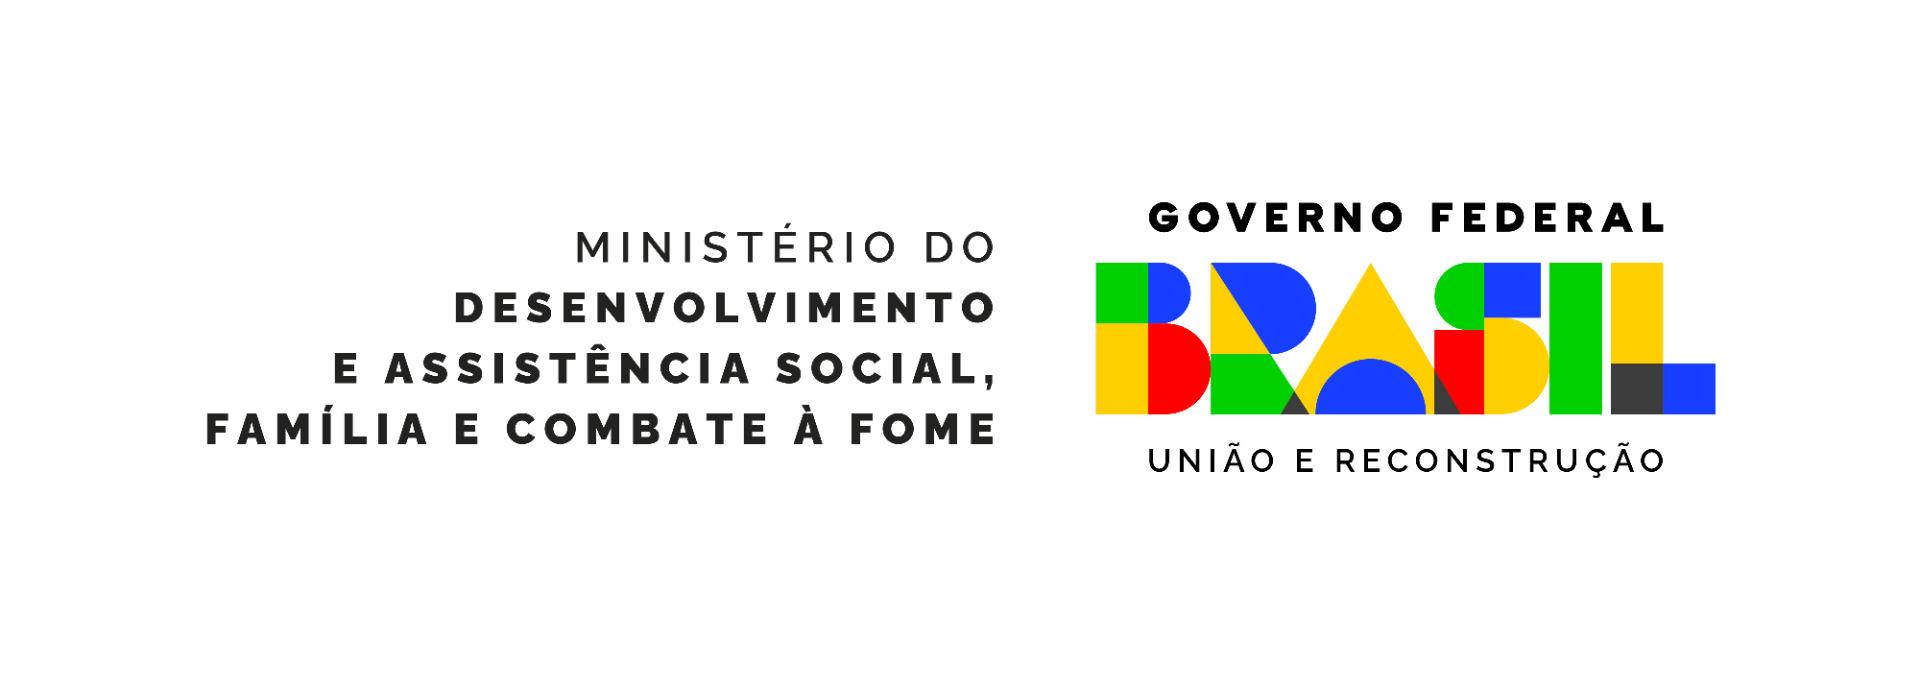

# Download do arquivo obtido com o MDS, contendo os microdados das pessoas inscritas no CadÚnico

Este arquivo traz dados referentes aos membros das famílias inscritas no CadÚnico.

In [334]:
id_arquivo_mds = "1VRcPMW6H4bUQO4o-sHthU3JWC7reahAg"
url_arquivo_mds = f"https://drive.google.com/uc?id={id_arquivo_mds}"
gdown.download(url_arquivo_mds, 'base_mds.csv', quiet = False)

Downloading...
From (original): https://drive.google.com/uc?id=1VRcPMW6H4bUQO4o-sHthU3JWC7reahAg
From (redirected): https://drive.google.com/uc?id=1VRcPMW6H4bUQO4o-sHthU3JWC7reahAg&confirm=t&uuid=a64c487b-e2cd-4757-81d2-8cd70947d4d9
To: /content/base_mds.csv
100%|██████████| 1.42G/1.42G [00:45<00:00, 31.0MB/s]


'base_mds.csv'

# Contando o número de linhas do arquivo

In [335]:
with open('base_mds.csv', encoding='utf-8') as f:
    num_linhas = sum(1 for linha in f)

# Excluindo a linha referente ao cabeçalho
num_registros = num_linhas - 1

print("O arquivo possui {:,} registros.".format(num_registros).replace(",", "."))


O arquivo possui 12.852.599 registros.


Aqui, cabe uma observação. Ao tentar criar o DataFrame com todas os 12.852.599 registros, obtive vários erros por utilização completa da memória RAM.

Para contornar esse problema, fiz testes carregando 1M, 2M, 3M, 4M, 5M e 6M de registros, respectivamente. Algumas vezes os testes davam certo, em outras eles falhavam. No entanto, nas vezes em que consegui executar o notebook, analisei percentuais de atributos categóricos como sexo, raça, escolaridade etc., além de estatísticas de atributos numéricos como renda familiar e idade.

Comparando os parâmetros de cada teste, as diferenças foram mínimas. Assim, por segurança, optei por carregar 1M de registros para a criação da camada Bronze.

# Criando a camada Bronze a partir do carregamento de 1.000.000 de linhas do arquivo csv

In [336]:
df_mds_bronze = pandas.read_csv('base_mds.csv', sep = ';', encoding = 'utf-8', low_memory = False, nrows = 1000000)
df_mds_bronze

cd_ibge  estrato  classf  id_familia  id_pessoa  cod_sexo_pessoa  \
0       3200805        2       3   1555504.0        1.0                2   
1       1503903        2       3   2151979.0        2.0                2   
2       3550308        2       1   5234172.0        3.0                2   
3       2612208        2       3   2851256.0        4.0                2   
4       2924009        2       3   1230168.0        5.0                2   
...         ...      ...     ...         ...        ...              ...   
999995  1600055        1       3     26020.0   999996.0                1   
999996  4122008        1       3    985463.0   999997.0                1   
999997  3549904        2       3   4099618.0   999998.0                1   
999998  3301702        2       2   4363368.0   999999.0                2   
999999  3107703        1       3   1527273.0  1000000.0                2   

        idade  cod_parentesco_rf_pessoa  cod_raca_cor_pessoa  \
0          44                         1                  1.0   
1           9                         3                  4.0   
2          59                         1                  1.0   
3          20                         1                  4.0   
4          13                         3                  4.0   
...       ...                       ...                  ...   
999995     31                         3                  4.0   
999996     34                         2                  4.0   
999997     26                         3                  1.0   
999998     46                         1                  4.0   
999999     20                         3                  4.0   

        cod_local_nascimento_pessoa  ...  cod_trabalho_12_meses_memb  \
0                               2.0  ...                         1.0   
1                               1.0  ...                         NaN   
2                               2.0  ...                         2.0   
3                               1.0  ...                         2.0   
4                               2.0  ...                         NaN   
...                             ...  ...                         ...   
999995                          2.0  ...                         2.0   
999996                          1.0  ...                         1.0   
999997                          1.0  ...                         2.0   
999998                          2.0  ...                         2.0   
999999                          2.0  ...                         1.0   

        qtd_meses_12_meses_memb  val_renda_bruta_12_meses_memb  \
0                          12.0                         3840.0   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            NaN   
...                         ...                            ...   
999995                      NaN                            NaN   
999996                     12.0                         3600.0   
999997                      NaN                            NaN   
999998                      NaN                            NaN   
999999                      2.0                          400.0   

        val_renda_doacao_memb  val_renda_aposent_memb  \
0                         0.0                     0.0   
1                         NaN                     0.0   
2                         0.0                   650.0   
3                       100.0                     0.0   
4                         NaN                     0.0   
...                       ...                     ...   
999995                    0.0                     0.0   
999996                    0.0                     0.0   
999997                    0.0                   937.0   
999998                    0.0                     0.0   
999999                    0.0            

#Conhecendo as colunas e seus tipos da camada Bronze

In [337]:
df_mds_bronze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 35 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   cd_ibge                           1000000 non-null  int64  
 1   estrato                           1000000 non-null  int64  
 2   classf                            1000000 non-null  int64  
 3   id_familia                        1000000 non-null  float64
 4   id_pessoa                         1000000 non-null  float64
 5   cod_sexo_pessoa                   1000000 non-null  int64  
 6   idade                             1000000 non-null  int64  
 7   cod_parentesco_rf_pessoa          1000000 non-null  int64  
 8   cod_raca_cor_pessoa               999597 non-null   float64
 9   cod_local_nascimento_pessoa       995752 non-null   float64
 10  cod_certidao_registrada_pessoa    1000000 non-null  int64  
 11  cod_deficiencia_memb              1000

Para o presente trabalho, somente 15 das 35 colunas serão relevantes. Abaixo, apresento o dicionário das colunas relevantes, construído a partir do original, disponibilizado pelo MDS em:

https://aplicacoes.mds.gov.br/sagi/dicivip_datain/ckfinder/userfiles/files/Dicionario_base_identificada_pt_R03.xlsx.

Vale também notar que colunas categóricas passaram por *Label Encoding*, já que todas as colunas são numéricas. Dessa forma, o dicionário abaixo também nos auxiliará a interpretar e, futuramente, decodificar essas colunas categóricas.

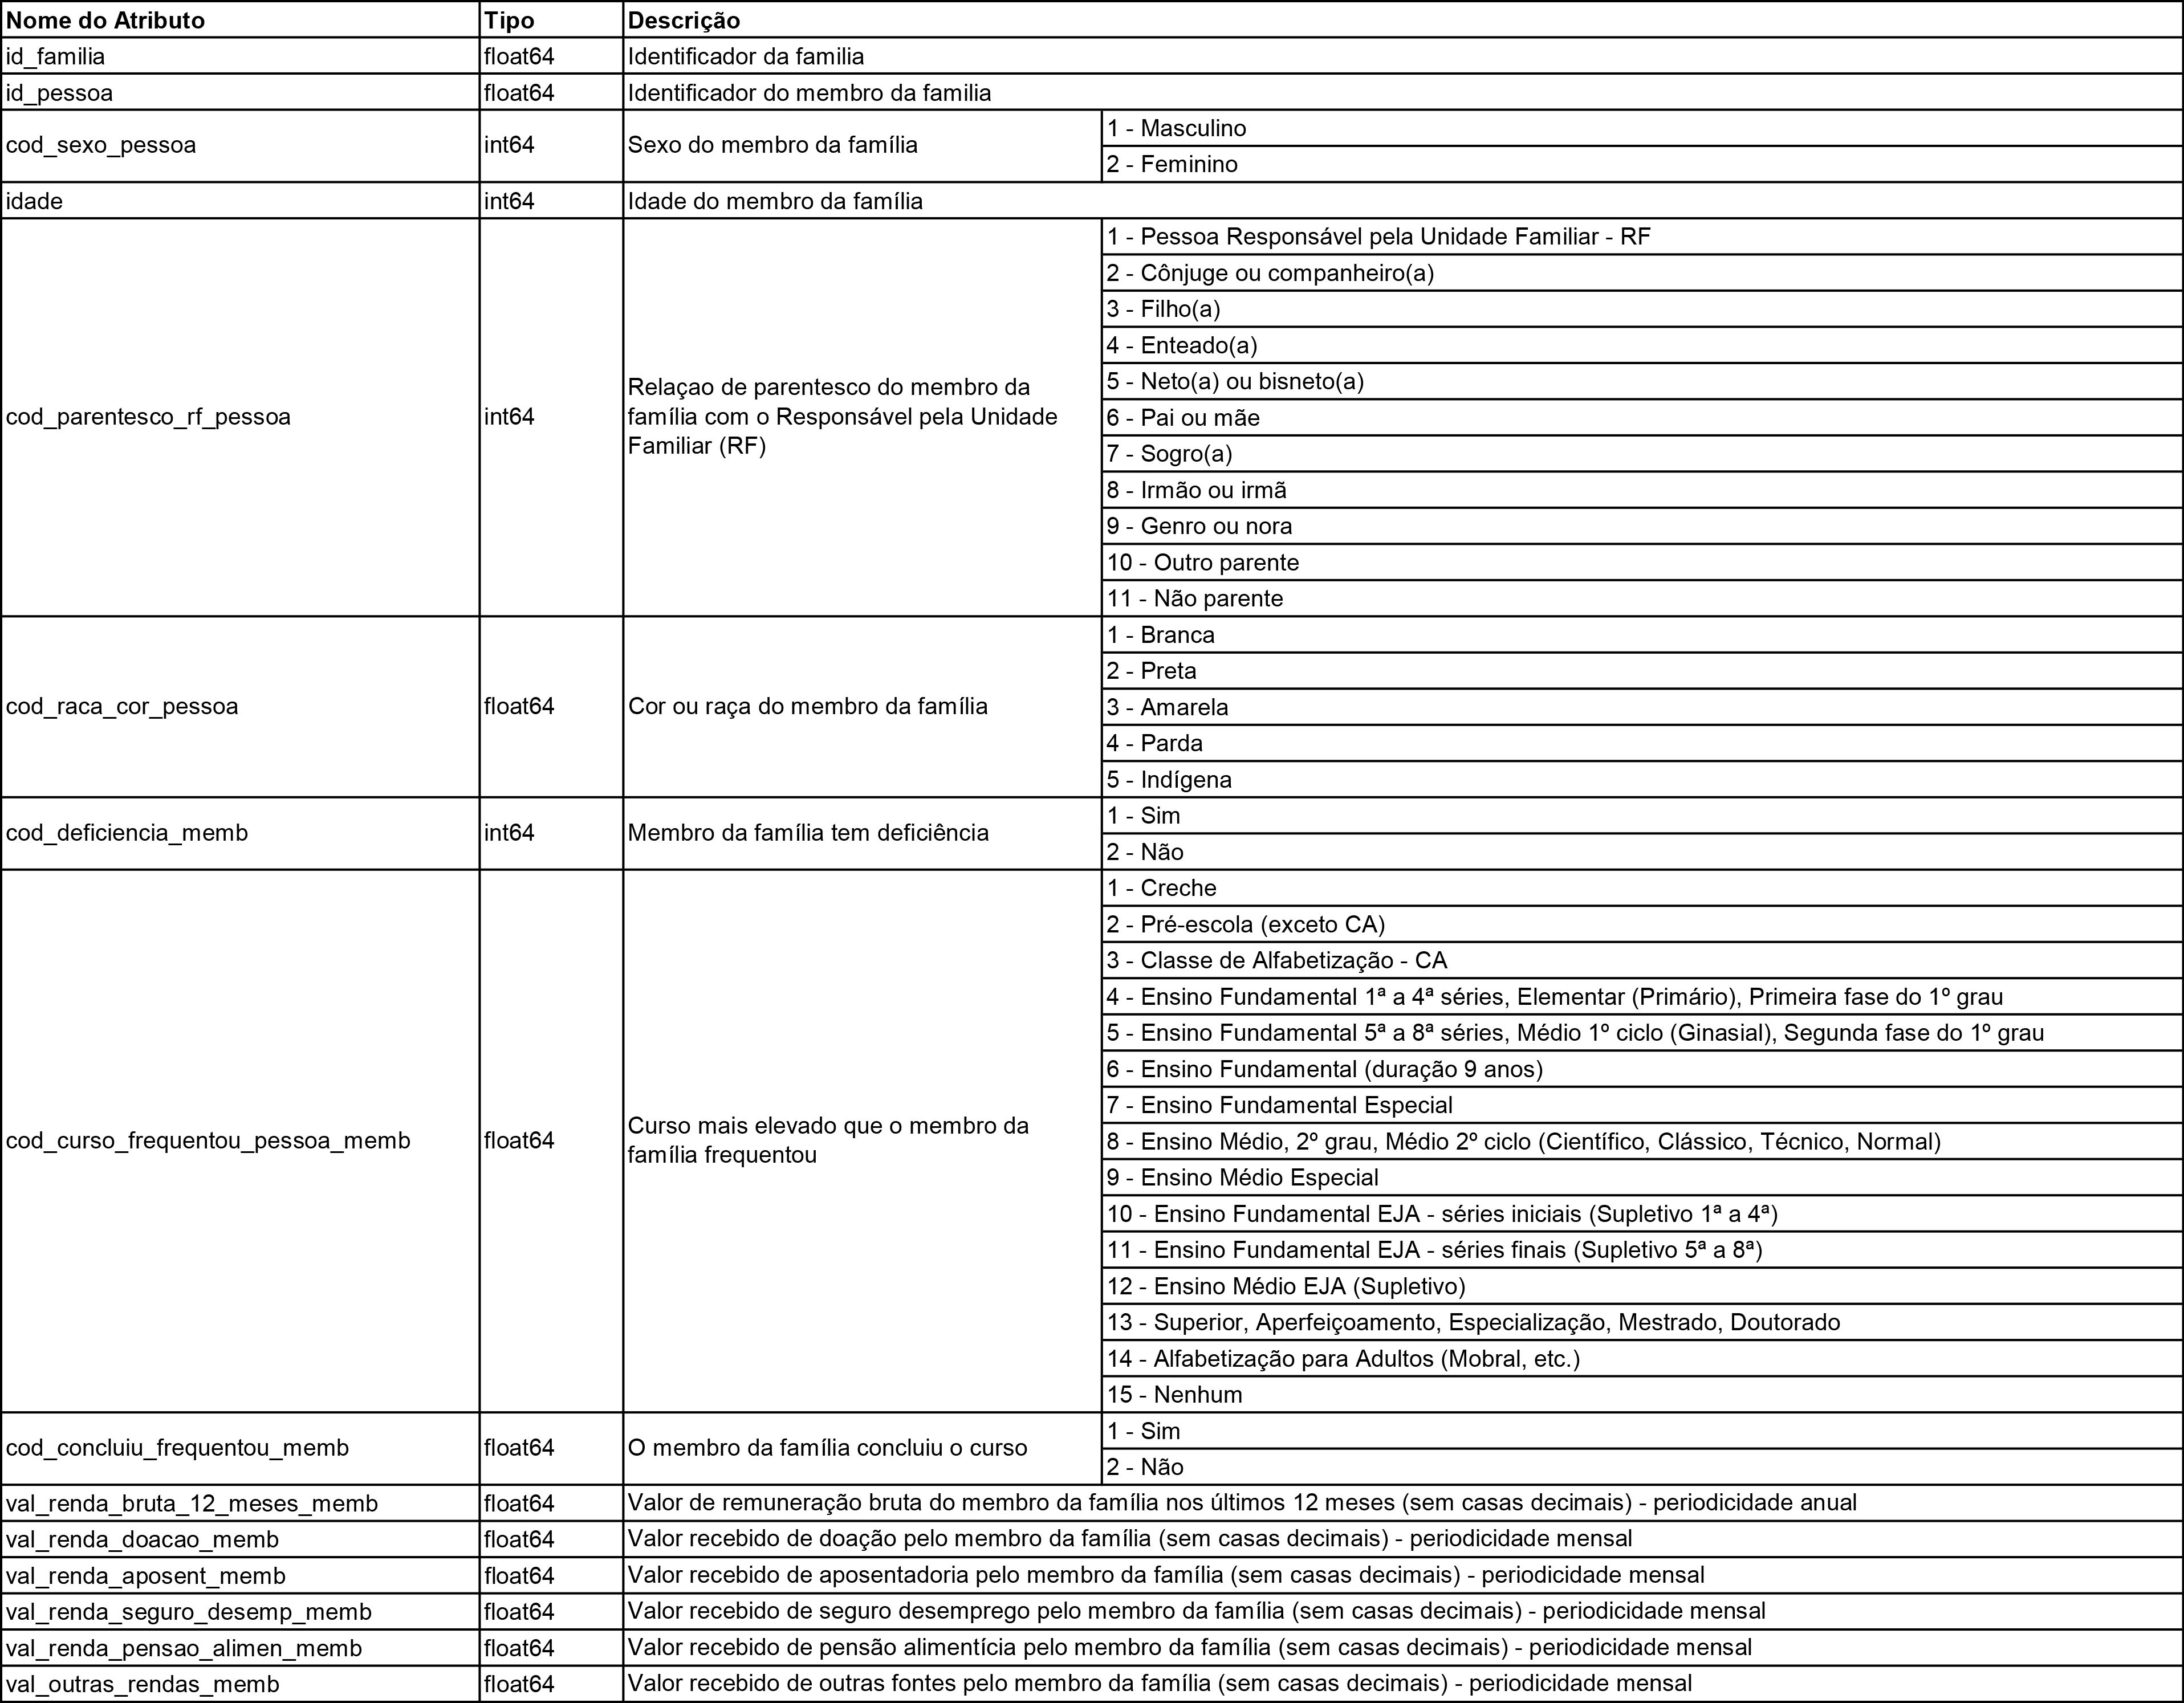

#Criando a camada Silver

In [338]:
#Criando a camada Silver com as colunas relevantes
df_mds_silver = df_mds_bronze[
    [
        'id_familia',
        'id_pessoa',
        'cod_sexo_pessoa',
        'idade',
        'cod_parentesco_rf_pessoa',
        'cod_raca_cor_pessoa',
        'cod_deficiencia_memb',
        'cod_curso_frequentou_pessoa_memb',
        'cod_concluiu_frequentou_memb',
        'val_renda_bruta_12_meses_memb',
        'val_renda_doacao_memb',
        'val_renda_aposent_memb',
        'val_renda_seguro_desemp_memb',
        'val_renda_pensao_alimen_memb',
        'val_outras_rendas_memb'
    ]
].copy()

df_mds_silver

id_familia  id_pessoa  cod_sexo_pessoa  idade  \
0        1555504.0        1.0                2     44   
1        2151979.0        2.0                2      9   
2        5234172.0        3.0                2     59   
3        2851256.0        4.0                2     20   
4        1230168.0        5.0                2     13   
...            ...        ...              ...    ...   
999995     26020.0   999996.0                1     31   
999996    985463.0   999997.0                1     34   
999997   4099618.0   999998.0                1     26   
999998   4363368.0   999999.0                2     46   
999999   1527273.0  1000000.0                2     20   

        cod_parentesco_rf_pessoa  cod_raca_cor_pessoa  cod_deficiencia_memb  \
0                              1                  1.0                     2   
1                              3                  4.0                     2   
2                              1                  1.0                     2   
3                              1                  4.0                     2   
4                              3                  4.0                     2   
...                          ...                  ...                   ...   
999995                         3                  4.0                     2   
999996                         2                  4.0                     2   
999997                         3                  1.0                     1   
999998                         1                  4.0                     2   
999999                         3                  4.0                     2   

        cod_curso_frequentou_pessoa_memb  cod_concluiu_frequentou_memb  \
0                                    4.0                           1.0   
1                                    NaN                           NaN   
2                                    5.0                           2.0   
3                                    8.0                           1.0   
4                                    NaN                           NaN   
...                                  ...                           ...   
999995                               8.0                           1.0   
999996                               4.0                           1.0   
999997                               7.0                           2.0   
999998                               8.0                           1.0   
999999                               8.0                           2.0   

        val_renda_bruta_12_meses_memb  val_renda_doacao_memb  \
0                              3840.0                    0.0   
1                                 NaN                    NaN   
2                                 NaN                    0.0   
3                                 NaN                  100.0   
4                                 NaN                    NaN   
...                               ...                    ...   
999995                            NaN                    0.0   
999996                         3600.0                    0.0   
999997                            NaN                    0.0   
999998                            NaN                    0.0   
999999                          400.0                    0.0   

        val_renda_aposent_memb  val_renda_seguro_desemp_memb  \
0                          0.0                           0.0   
1                          0.0                           NaN   
2                        650.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           NaN   
...                        ...                           ...   
999995                     0.0                           0.0   
999996                     0.0                           0.0   
999997                   937.0                           0.0   
999998                     0.0                           0.0   
999999      

#Fazendo uma análise estatística da camada Silver antes da limpeza de dados

Vamos fazer uma análise estatística da camada Silver.

Essa análise, no entanto, só faz sentido para atributos que são de fato numéricos. Portanto, vamos ignorar os atributos categóricos que estão codificados por *Label Encoding*.

Para isso, vamos consultar o dicionário de dados, e restringir nosso DataFrame ao aplicar o método describe().

In [339]:
#Selecionando as colunas que são, de fato, numéricas
colunas_numericas = [
  'idade',
  'val_renda_bruta_12_meses_memb',
  'val_renda_doacao_memb',
  'val_renda_aposent_memb',
  'val_renda_seguro_desemp_memb',
  'val_renda_pensao_alimen_memb',
  'val_outras_rendas_memb'
]

#Calculando o describe
tabela_desc = df_mds_silver[colunas_numericas].describe()

#Aplica a formatação no padrão brasileiro
for col in tabela_desc.columns:
    tabela_desc[col] = tabela_desc[col].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

#Exibindo a tabela formatada
tabela_desc


idade val_renda_bruta_12_meses_memb val_renda_doacao_memb  \
count  1.000.000,00                    239.842,00            663.780,00   
mean          26,76                      5.039,35                  9,33   
std           20,34                      5.565,41                 55,39   
min            0,00                          0,00                  0,00   
25%           10,00                      1.000,00                  0,00   
50%           22,00                      2.800,00                  0,00   
75%           41,00                      8.376,00                  0,00   
max          130,00                     99.990,00              2.500,00   

      val_renda_aposent_memb val_renda_seguro_desemp_memb  \
count             997.785,00                   663.780,00   
mean                   97,15                         3,85   
std                   299,54                        63,19   
min                     0,00                         0,00   
25%                     0,00                         0,00   
50%                     0,00                         0,00   
75%                     0,00                         0,00   
max                 3.088,00                     2.500,00   

      val_renda_pensao_alimen_memb val_outras_rendas_memb  
count                   997.776,00             663.804,00  
mean                          6,27                   6,67  
std                          44,26                  62,75  
min                           0,00                   0,00  
25%                           0,00                   0,00  
50%                           0,00                   0,00  
75%                           0,00                   0,00  
max                       2.840,00               2.780,00

Considerando que esse DataFrame relaciona todos os membros de diversas famílias de baixa renda (incluindo crianças e idosos), parece-me que a média da renda bruta anual (`val_renda_bruta_12_meses_memb`) de R\$ 5.033,48 está bastante alta. Isso talvez aconteça porque, no cálculo da média, campos `Null` ou `NaN` são ignorados. E isso também deve estar acontecendo nas outras colunas referentes à renda.

Além disso, as regras para que uma família possa se inscrever no CadÚnico mudaram algumas vezes ao longo dos anos. Hoje, são elas:

* Famílias com renda mensal de até meio salário mínimo por pessoa, ou seja, até R\$ 706,00 por pessoa (salário mínimo atual: R\$ 1.412,00);

* Famílias com renda mensal total de até 3 salários mínimos, ou seja, até R\$ 4.236,00 no total da casa;

* Pessoas ou famílias em situação de rua, com ou sem renda;

* Famílias com renda maior, mas:
  * Que tenham pessoas com deficiência
  * Ou que estejam em situação de vulnerabilidade, e necessitem de programas sociais

Dessa forma, certamente temos um número considerável de cadastros nessa base de dados que, hoje, não poderiam ser cadastradas. Assim, chegaríamos a conclusões mais corretas se eliminássemos esses dados.

Vamos, portanto, proceder à limpeza de dados.

#Fazendo a limpeza de dados na camada Silver

In [340]:
#Verificando se há registros sem id_familia
qtd = df_mds_silver['id_familia'].isna().sum()
print(f"Quantidade de registros sem id_familia: {qtd:,}".replace(",", "."))

Quantidade de registros sem id_familia: 0


In [341]:
#Verificando se há registros sem id_pessoa
qtd = df_mds_silver['id_pessoa'].isna().sum()
print(f"Quantidade de registros sem id_pessoa: {qtd:,}".replace(",", "."))

Quantidade de registros sem id_pessoa: 0


In [342]:
#Verificando se há registros sem cod_sexo_pessoa
qtd = df_mds_silver['cod_sexo_pessoa'].isna().sum()
print(f"Quantidade de registros sem cod_sexo_pessoa: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_sexo_pessoa fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_sexo_pessoa'].isin([1, 2])]
print(f"Quantidade de registros com cod_sexo_pessoa fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_sexo_pessoa: 0
Quantidade de registros com cod_sexo_pessoa fora do domínio: 0


In [343]:
#Verificando se há registros sem idade
qtd = df_mds_silver['idade'].isna().sum()
print(f"Quantidade de registros sem idade: {qtd:,}".replace(",", "."))

Quantidade de registros sem idade: 0


In [344]:
#Verificando se há idades atípicas
df_mds_silver['idade'].value_counts(dropna=False).sort_index()

idade
0      40201
1      22392
2      22477
3      22049
4      22373
       ...  
116        6
120        1
125        1
129        1
130        1
Name: count, Length: 118, dtype: int64

Apesar de raros, existem casos de pessoas que passam dos 100 anos. E como as quantidades dessas pessoas do DataFrame não são desproporcionalmente significativas, os dados parecem-me coerentes.

In [345]:
#Verificando se há registros sem cod_parentesco_rf_pessoa
qtd = df_mds_silver['cod_parentesco_rf_pessoa'].isna().sum()
print(f"Quantidade de registros sem cod_parentesco_rf_pessoa: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_parentesco_rf_pessoa fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_parentesco_rf_pessoa'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
print(f"Quantidade de registros com cod_parentesco_rf_pessoa fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_parentesco_rf_pessoa: 0
Quantidade de registros com cod_parentesco_rf_pessoa fora do domínio: 0


In [346]:
#Verificando se há registros sem cod_raca_cor_pessoa
qtd = df_mds_silver['cod_raca_cor_pessoa'].isna().sum()
print(f"Quantidade de registros sem cod_raca_cor_pessoa: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_raca_cor_pessoa fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_raca_cor_pessoa'].isin([1, 2, 3, 4, 5])]
print(f"Quantidade de registros com cod_raca_cor_pessoa fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_raca_cor_pessoa: 403
Quantidade de registros com cod_raca_cor_pessoa fora do domínio: 403


Aqui, não há de fato um problema, já que a base interna da Ação da Cidadania, com a qual a base do MDS será comparada ao longo do presente trabalho, permite que o entrevistado não informe raça ou cor. Dessa forma, os 1.551 dados faltantes poderão ser interpretados futuramente como "não informados".

In [347]:
#Verificando se há registros sem cod_deficiencia_memb
qtd = df_mds_silver['cod_deficiencia_memb'].isna().sum()
print(f"Quantidade de registros sem cod_deficiencia_memb: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_deficiencia_memb fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_deficiencia_memb'].isin([1, 2])]
print(f"Quantidade de registros com cod_deficiencia_memb fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_deficiencia_memb: 0
Quantidade de registros com cod_deficiencia_memb fora do domínio: 0


In [348]:
#Verificando se há registros sem cod_curso_frequentou_pessoa_memb
qtd = df_mds_silver['cod_curso_frequentou_pessoa_memb'].isna().sum()
print(f"Quantidade de registros sem cod_curso_frequentou_pessoa_memb: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_curso_frequentou_pessoa_memb fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_curso_frequentou_pessoa_memb'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15])]
print(f"Quantidade de registros com cod_curso_frequentou_pessoa_memb fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_curso_frequentou_pessoa_memb: 481.734
Quantidade de registros com cod_curso_frequentou_pessoa_memb fora do domínio: 481.734


Aqui, também não há um problema. De forma análoga à raça/cor, os 1.928.385 dados faltantes poderão ser interpretados futuramente como "não informados".

In [349]:
#Verificando se há registros sem cod_concluiu_frequentou_memb
qtd = df_mds_silver['cod_concluiu_frequentou_memb'].isna().sum()
print(f"Quantidade de registros sem cod_concluiu_frequentou_memb: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_concluiu_frequentou_memb fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_concluiu_frequentou_memb'].isin([1, 2])]
print(f"Quantidade de registros com cod_concluiu_frequentou_memb fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_concluiu_frequentou_memb: 507.065
Quantidade de registros com cod_concluiu_frequentou_memb fora do domínio: 507.065


Neste caso, parece-me mais justo considerar os dados faltantes referentes à conclusão da escolaridade como "não".

In [350]:
#Substituindo NaN em cod_concluiu_frequentou_memb por 2 ("Não")
df_mds_silver['cod_concluiu_frequentou_memb'] = df_mds_silver['cod_concluiu_frequentou_memb'].fillna(2)

#Conferindo

#Verificando se há registros sem cod_concluiu_frequentou_memb
qtd = df_mds_silver['cod_concluiu_frequentou_memb'].isna().sum()
print(f"Quantidade de registros sem cod_concluiu_frequentou_memb: {qtd:,}".replace(",", "."))

#Verificando se há registros com cod_concluiu_frequentou_memb fora do domínio
fora_dominio = df_mds_silver[~df_mds_silver['cod_concluiu_frequentou_memb'].isin([1, 2])]
print(f"Quantidade de registros com cod_concluiu_frequentou_memb fora do domínio: {len(fora_dominio):,}".replace(",", "."))

Quantidade de registros sem cod_concluiu_frequentou_memb: 0
Quantidade de registros com cod_concluiu_frequentou_memb fora do domínio: 0


In [351]:
#Verificando se há registros sem algum tipo de renda
colunas_renda = [
    'val_renda_bruta_12_meses_memb',
    'val_renda_doacao_memb',
    'val_renda_aposent_memb',
    'val_renda_seguro_desemp_memb',
    'val_renda_pensao_alimen_memb',
    'val_outras_rendas_memb'
]

df_mds_silver[colunas_renda].isna().sum()

val_renda_bruta_12_meses_memb    760158
val_renda_doacao_memb            336220
val_renda_aposent_memb             2215
val_renda_seguro_desemp_memb     336220
val_renda_pensao_alimen_memb       2224
val_outras_rendas_memb           336196
dtype: int64

Observando o relatório acima, percebemos que há diversos registros sem informação (Null ou NaN) nas colunas referentes às rendas.

Ora, parece-me que, na ausência dessas informações, seria justo e lógico substituí-las por zero. Afinal, qualquer outra substituição (pela média ou pela mediana, por exemplo), afastaria as inferências da realidade.

In [352]:
#Substituindo rendas faltantes por 0
df_mds_silver[colunas_renda] = df_mds_silver[colunas_renda].fillna(0)

#Conferindo
df_mds_silver[colunas_renda].isna().sum()

val_renda_bruta_12_meses_memb    0
val_renda_doacao_memb            0
val_renda_aposent_memb           0
val_renda_seguro_desemp_memb     0
val_renda_pensao_alimen_memb     0
val_outras_rendas_memb           0
dtype: int64

#Fazendo uma análise estatística da camada Silver depois da limpeza de dados

Feita a limpeza dos dados, vamos fazer uma nova análise estatística da camada Silver.

Mais uma vez, essa análise só faz sentido para atributos que são de fato numéricos.

In [353]:
#Calculando o describe
tabela_desc = df_mds_silver[colunas_numericas].describe()

#Formatando cada coluna com map()
for col in tabela_desc.columns:
    tabela_desc[col] = tabela_desc[col].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

#Exibindo
print(tabela_desc)


              idade val_renda_bruta_12_meses_memb val_renda_doacao_memb  \
count  1.000.000,00                  1.000.000,00          1.000.000,00   
mean          26,76                      1.208,65                  6,19   
std           20,34                      3.472,57                 45,35   
min            0,00                          0,00                  0,00   
25%           10,00                          0,00                  0,00   
50%           22,00                          0,00                  0,00   
75%           41,00                          0,00                  0,00   
max          130,00                     99.990,00              2.500,00   

      val_renda_aposent_memb val_renda_seguro_desemp_memb  \
count           1.000.000,00                 1.000.000,00   
mean                   96,93                         2,56   
std                   299,24                        51,52   
min                     0,00                         0,00   
25%                

É importante notar que há 6 atributos referentes às rendas dessas pessoas. Além disso, consultando o dicionário de dados, notamos que esses atributos não têm a mesma periodicidade:

* `val_renda_bruta_12_meses_memb`, de periodicidade ***anual***;
* `val_renda_doacao_memb`, de periodicidade ***mensal***;
* `val_renda_aposent_memb`, de periodicidade ***mensal***;
* `val_renda_seguro_desemp_memb`, de periodicidade ***mensal***;
* `val_renda_pensao_alimen_memb`, de periodicidade ***mensal***;
* `val_outras_rendas_memb`, de periodicidade ***mensal***.

Vamos, portanto, criar um novo atributo, chamado `renda_total_pessoa`, de periodicidade ***mensal*** . Para isso, vamos converter a periodicidade de `val_renda_bruta_12_meses_memb` para ***mensal*** e somar o resultado a todas as outras fontes de renda.





#Acrescentando a nova coluna `renda_total_pessoa` à camada Silver

In [354]:
df_mds_silver['renda_total_pessoa'] = (
    df_mds_silver['val_renda_bruta_12_meses_memb'] / 12 +
    df_mds_silver['val_renda_doacao_memb'] +
    df_mds_silver['val_renda_aposent_memb'] +
    df_mds_silver['val_renda_seguro_desemp_memb'] +
    df_mds_silver['val_renda_pensao_alimen_memb'] +
    df_mds_silver['val_outras_rendas_memb']
)

df_mds_silver[
    [
      'id_familia',
      'val_renda_bruta_12_meses_memb',
      'val_renda_doacao_memb',
      'val_renda_aposent_memb',
      'val_renda_seguro_desemp_memb',
      'val_renda_pensao_alimen_memb',
      'val_outras_rendas_memb',
      'renda_total_pessoa'
    ]
]

id_familia  val_renda_bruta_12_meses_memb  val_renda_doacao_memb  \
0        1555504.0                         3840.0                    0.0   
1        2151979.0                            0.0                    0.0   
2        5234172.0                            0.0                    0.0   
3        2851256.0                            0.0                  100.0   
4        1230168.0                            0.0                    0.0   
...            ...                            ...                    ...   
999995     26020.0                            0.0                    0.0   
999996    985463.0                         3600.0                    0.0   
999997   4099618.0                            0.0                    0.0   
999998   4363368.0                            0.0                    0.0   
999999   1527273.0                          400.0                    0.0   

        val_renda_aposent_memb  val_renda_seguro_desemp_memb  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                        650.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   
...                        ...                           ...   
999995                     0.0                           0.0   
999996                     0.0                           0.0   
999997                   937.0                           0.0   
999998                     0.0                           0.0   
999999                     0.0                           0.0   

        val_renda_pensao_alimen_memb  val_outras_rendas_memb  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   
...                              ...                     ...   
999995                           0.0                     0.0   
999996                           0.0                     0.0   
999997                           0.0                     0.0   
999998                           0.0                     0.0   
999999                           0.0                     0.0   

        renda_total_pessoa  
0               320.000000  
1                 0.000000  
2               650.000000  
3               100.000000  
4                 0.000000  
...                    ...  
999995            0.000000  
999996          300.000000  
999997          937.000000  
999998            0.000000  
999999           33.333333  

[1000000 rows x 8 columns]

#Criando a camada Gold

Com o objetivo de compararmos os dados da Ação da Cidadania com os do MDS, vamos montar um DataFrame que traga informações consolidadas sobre as rendas das ***famílias***. Para isso, vamos agrupar os registros por `id_familia`.

Além disso, vamos manter os dados sociodemográficos referentes ao ***responsável pela família*** (`cod_parentesco_rf_pessoa = 1`).

In [355]:
df_mds_gold = duckdb.query("""
    WITH renda_por_familia AS (
        SELECT
            id_familia,
            COUNT(*) AS qtd_membros,
            ROUND(SUM(renda_total_pessoa), 2) AS renda_familiar
        FROM df_mds_silver
        GROUP BY id_familia
    ),

    dados_responsaveis AS (
        SELECT
            id_familia,
            idade,
            cod_sexo_pessoa,
            cod_raca_cor_pessoa,
            cod_deficiencia_memb,
            cod_curso_frequentou_pessoa_memb,
            cod_concluiu_frequentou_memb
        FROM df_mds_silver
        WHERE cod_parentesco_rf_pessoa = 1
    )

    SELECT
        renda_por_familia.id_familia,
        renda_por_familia.renda_familiar,
        renda_por_familia.qtd_membros,
        ROUND(renda_por_familia.renda_familiar * 1.0 / renda_por_familia.qtd_membros, 2) AS renda_per_capita,
        dados_responsaveis.idade,
        dados_responsaveis.cod_sexo_pessoa,
        dados_responsaveis.cod_raca_cor_pessoa,
        dados_responsaveis.cod_deficiencia_memb,
        dados_responsaveis.cod_curso_frequentou_pessoa_memb,
        dados_responsaveis.cod_concluiu_frequentou_memb
    FROM renda_por_familia
    JOIN dados_responsaveis ON renda_por_familia.id_familia = dados_responsaveis.id_familia
""").to_df()

df_mds_gold


id_familia  renda_familiar  qtd_membros  renda_per_capita  idade  \
0        5235463.0          891.00            1            891.00     62   
1        3631866.0         1297.00            1           1297.00     44   
2        1454738.0            0.00            1              0.00     21   
3        1321684.0          937.00            1            937.00     54   
4        2254808.0            0.00            1              0.00     27   
...            ...             ...          ...               ...    ...   
372631    883701.0          964.00            1            964.00     67   
372632   2921260.0           25.00            1             25.00     21   
372633    484607.0           26.67            1             26.67     48   
372634    983734.0          780.00            1            780.00     36   
372635   5157348.0            0.00            1              0.00     51   

        cod_sexo_pessoa  cod_raca_cor_pessoa  cod_deficiencia_memb  \
0                     2                  1.0                     2   
1                     1                  4.0                     2   
2                     2                  1.0                     2   
3                     1                  4.0                     2   
4                     2                  4.0                     2   
...                 ...                  ...                   ...   
372631                2                  1.0                     2   
372632                2                  4.0                     2   
372633                2                  4.0                     2   
372634                2                  4.0                     2   
372635                1                  4.0                     2   

        cod_curso_frequentou_pessoa_memb  cod_concluiu_frequentou_memb  
0                                    4.0                           1.0  
1                                    8.0                           1.0  
2                                    6.0                           1.0  
3                                    5.0                           2.0  
4                                    5.0                           2.0  
...                                  ...                           ...  
372631                               4.0                           2.0  
372632                               8.0                           1.0  
372633                               5.0                           2.0  
372634                               4.0                           2.0  
372635                               5.0                           2.0  

[372636 rows x 10 columns]

Agora que a camada Gold se refere a ***famílias***, e não a ***pessoas***, podemos aplicar os filtros para excluir os cadastros que não obedecem as condições para inscrição no CadÚnico.

In [356]:
#Criando o filtro
filtro = (
    (df_mds_gold["renda_per_capita"] <= 706) |
    (df_mds_gold["renda_familiar"] <= 4236) |
    (df_mds_gold["cod_deficiencia_memb"] == 1) |
    (df_mds_gold["renda_per_capita"].isna()) |
    (df_mds_gold["renda_familiar"].isna()) |
    (df_mds_gold["renda_per_capita"] == 0) |
    (df_mds_gold["renda_familiar"] == 0)
)

#Aplicando o filtro
df_mds_gold = df_mds_gold[filtro].copy()

df_mds_gold


id_familia  renda_familiar  qtd_membros  renda_per_capita  idade  \
0        5235463.0          891.00            1            891.00     62   
1        3631866.0         1297.00            1           1297.00     44   
2        1454738.0            0.00            1              0.00     21   
3        1321684.0          937.00            1            937.00     54   
4        2254808.0            0.00            1              0.00     27   
...            ...             ...          ...               ...    ...   
372631    883701.0          964.00            1            964.00     67   
372632   2921260.0           25.00            1             25.00     21   
372633    484607.0           26.67            1             26.67     48   
372634    983734.0          780.00            1            780.00     36   
372635   5157348.0            0.00            1              0.00     51   

        cod_sexo_pessoa  cod_raca_cor_pessoa  cod_deficiencia_memb  \
0                     2                  1.0                     2   
1                     1                  4.0                     2   
2                     2                  1.0                     2   
3                     1                  4.0                     2   
4                     2                  4.0                     2   
...                 ...                  ...                   ...   
372631                2                  1.0                     2   
372632                2                  4.0                     2   
372633                2                  4.0                     2   
372634                2                  4.0                     2   
372635                1                  4.0                     2   

        cod_curso_frequentou_pessoa_memb  cod_concluiu_frequentou_memb  
0                                    4.0                           1.0  
1                                    8.0                           1.0  
2                                    6.0                           1.0  
3                                    5.0                           2.0  
4                                    5.0                           2.0  
...                                  ...                           ...  
372631                               4.0                           2.0  
372632                               8.0                           1.0  
372633                               5.0                           2.0  
372634                               4.0                           2.0  
372635                               5.0                           2.0  

[372549 rows x 10 columns]

In [357]:
#Definindo colunas numéricas
colunas_numericas = [
    'idade',
    'renda_familiar',
    'renda_per_capita'
]

#Calculando o describe
tabela_desc = df_mds_gold[colunas_numericas].describe()

#Formatando cada coluna com map()
for col in tabela_desc.columns:
    tabela_desc[col] = tabela_desc[col].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

#Exibindo
print(tabela_desc)

            idade renda_familiar renda_per_capita
count  372.549,00     372.549,00       372.549,00
mean        41,50         373,62           347,71
std         15,69         464,26           438,23
min         14,00           0,00             0,00
25%         29,00           0,00             0,00
50%         39,00         150,00           125,00
75%         52,00         800,00           724,00
max        130,00       6.763,33         6.763,33


#Decodificando dados categóricos da camada Gold

Para podermos fazer a comparação entre as bases de dados, vamos recorrer ao dicionário de dados para fazer a decodificação dos dados categóricos.

Mas antes, uma observação: criaremos uma coluna chamada `escolaridade` a partir das colunas `cod_curso_frequentou_pessoa_memb` e `cod_concluiu_frequentou_memb`. Porém, na decodificação dessa coluna, não usaremos os valores relacionados no dicionário de dados do MDS, mas sim os valores com os quais trabalhamos internamente na Ação da Cidadania, para que a comparação possa ser feita. São eles:

* Ensino Infantil incompleto;
* Ensino Infantil completo;
* Ensino Fundamental incompleto;
* Ensino Fundamental completo;
* Ensino Médio incompleto;
* Ensino Médio completo;
* Ensino Superior incompleto;
* Ensino Superior completo;
* Não possui escolaridade.

In [358]:
df_mds_gold = duckdb.query("""
  SELECT

    id_familia,
    renda_familiar,
    qtd_membros,
    renda_per_capita,
    idade,

    CASE cod_sexo_pessoa
      WHEN 1 THEN 'Masculino'
      WHEN 2 THEN 'Feminino'
      ELSE 'Não informado'
    END AS sexo,

    CASE cod_raca_cor_pessoa
      WHEN 1 THEN 'Branca'
      WHEN 2 THEN 'Preta'
      WHEN 3 THEN 'Amarela'
      WHEN 4 THEN 'Parda'
      WHEN 5 THEN 'Indígena'
      ELSE 'Não informado'
    END AS raca_cor,

    CASE cod_deficiencia_memb
      WHEN 1 THEN 'Sim'
      WHEN 2 THEN 'Não'
      ELSE 'Não informado'
    END AS pcd,

    CASE cod_curso_frequentou_pessoa_memb
      WHEN  1 THEN 'Ensino Infantil'
      WHEN  2 THEN 'Ensino Infantil'
      WHEN  3 THEN 'Ensino Fundamental'
      WHEN  4 THEN 'Ensino Fundamental'
      WHEN  5 THEN 'Ensino Fundamental'
      WHEN  6 THEN 'Ensino Fundamental'
      WHEN  7 THEN 'Ensino Fundamental'
      WHEN  8 THEN 'Ensino Médio'
      WHEN  9 THEN 'Ensino Médio'
      WHEN 10 THEN 'Ensino Fundamental'
      WHEN 11 THEN 'Ensino Fundamental'
      WHEN 12 THEN 'Ensino Médio'
      WHEN 13 THEN 'Ensino Superior'
      WHEN 14 THEN 'Ensino Fundamental'
      WHEN 15 THEN 'Não possui escolaridade'
      ELSE 'Não informado'
    END ||
    CASE
      WHEN cod_curso_frequentou_pessoa_memb IN (1,2,3,4,5,6,7,8,9,10,11,12,13,14)
        THEN
          CASE cod_concluiu_frequentou_memb
            WHEN 1 THEN ' completo'
            WHEN 2 THEN ' incompleto'
            ELSE ''
          END
      ELSE ''
    END AS escolaridade

  FROM df_mds_gold
""").to_df()

df_mds_gold

id_familia  renda_familiar  qtd_membros  renda_per_capita  idade  \
0        5235463.0           891.0            1             891.0     62   
1        3631866.0          1297.0            1            1297.0     44   
2        1454738.0             0.0            1               0.0     21   
3        1321684.0           937.0            1             937.0     54   
4        2254808.0             0.0            1               0.0     27   
...            ...             ...          ...               ...    ...   
372544   1921277.0             0.0            1               0.0     36   
372545   3408273.0           720.0            1             720.0     31   
372546   1683173.0             0.0            1               0.0     31   
372547   4686675.0           937.0            1             937.0     38   
372548   5028144.0           300.0            1             300.0     37   

             sexo raca_cor  pcd                   escolaridade  
0        Feminino   Branca  Não    Ensino Fundamental completo  
1       Masculino    Parda  Não          Ensino Médio completo  
2        Feminino   Branca  Não    Ensino Fundamental completo  
3       Masculino    Parda  Não  Ensino Fundamental incompleto  
4        Feminino    Parda  Não  Ensino Fundamental incompleto  
...           ...      ...  ...                            ...  
372544   Feminino    Parda  Não  Ensino Fundamental incompleto  
372545   Feminino    Preta  Não  Ensino Fundamental incompleto  
372546   Feminino   Branca  Não  Ensino Fundamental incompleto  
372547   Feminino    Parda  Sim    Ensino Fundamental completo  
372548  Masculino   Branca  Não    Ensino Fundamental completo  

[372549 rows x 9 columns]

Assim finalizamos a manipulação dos dados obtidos do MDS. Vamos, agora, trabalhar com os dados do projeto Busca Ativa, da Ação da Cidadania.

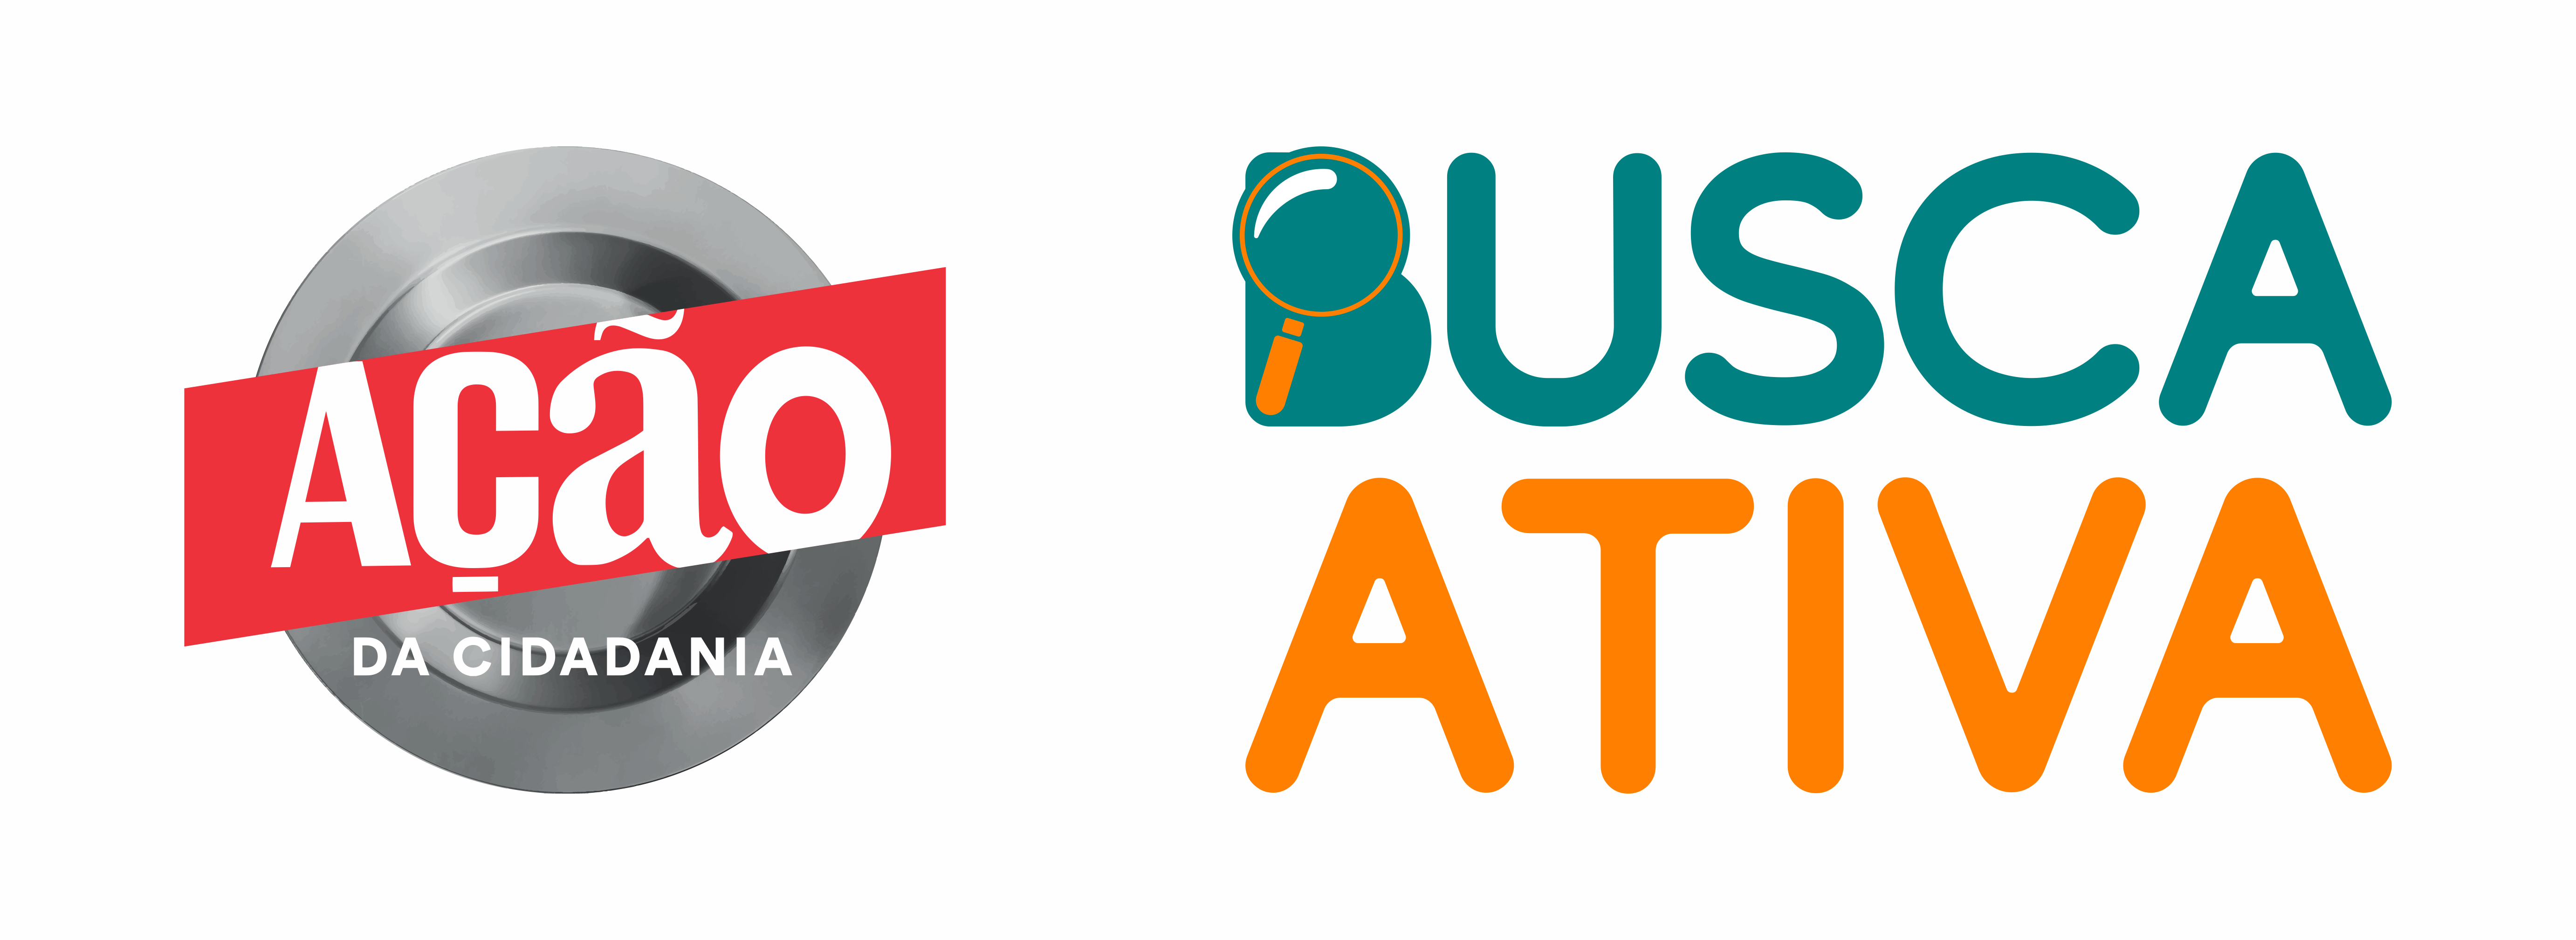

#Download do arquivo contendo os microdados das famílias entrevistadas no projeto Busca Ativa, da Ação da Cidadania

In [359]:
id_arquivo_acao = "16dNrlFpveLS21xu6donHRr8cjJ_XCklh"
url_arquivo_acao = f"https://drive.google.com/uc?id={id_arquivo_acao}"
gdown.download(url_arquivo_acao, 'base_acao.csv', quiet = False)

Downloading...
From: https://drive.google.com/uc?id=16dNrlFpveLS21xu6donHRr8cjJ_XCklh
To: /content/base_acao.csv
100%|██████████| 1.75M/1.75M [00:00<00:00, 139MB/s]


'base_acao.csv'

#Criando a camada Bronze a partir do carregamento do arquivo csv

In [360]:
df_acao_bronze = pandas.read_csv('base_acao.csv', sep = ';', encoding = 'utf-8', low_memory = False)
df_acao_bronze

cod_familia                                  nome_civil  \
0     2025-05-24-R-7320   #########################################   
1     2025-03-25-R-4822                  ##########################   
2     2025-06-26-R-7914          ##################################   
3     2025-05-31-R-2464             ###############################   
4     2024-05-11-R-8969                 ###########################   
...                 ...                                         ...   
6525  2023-10-31-R-6242               #############################   
6526  2023-10-31-R-6637  ##########################################   
6527  2023-11-03-R-6303                   #########################   
6528  2023-11-03-R-2970     #######################################   
6529  2025-05-13-R-2633  ##########################################   

     pessoa_trans                                 nome_social          cpf  \
0             Não   #########################################  ###########   
1             Não                  ##########################  ###########   
2             Não          ##################################  ###########   
3             Não             ###############################  ###########   
4             Não                 ###########################  ###########   
...           ...                                         ...          ...   
6525          Não               #############################  ###########   
6526          Não  ##########################################  ###########   
6527          Não                   #########################  ###########   
6528          Não     #######################################  ###########   
6529          Não  ##########################################  ###########   

     data_nascimento  idade       sexo raca_cor  pcd  ... renda_familiar  \
0         1996-05-14   29.0  Masculino   Branca  Não  ...           4500   
1         1988-08-09   36.0   Feminino    Parda  Não  ...           4000   
2         1978-03-06   47.0  Masculino   Branca  Não  ...           4000   
3         1978-09-19   46.0   Feminino    Parda  Não  ...           3300   
4         1964-05-13   61.0   Feminino    Parda  Não  ...           6300   
...              ...    ...        ...      ...  ...  ...            ...   
6525      1988-05-23   37.0   Feminino    Parda  Não  ...              0   
6526      2000-10-10   24.0   Feminino    Parda  Não  ...              0   
6527      1988-05-23   37.0  Masculino   Branca  Não  ...              0   
6528      1988-05-23   37.0   Feminino    Parda  Não  ...              0   
6529             NaN    NaN  Masculino   Branca  Não  ...              0   

      membros_familia  renda_per_capita       fonte_renda  gestante  \
0                   1            4500.0   Trabalho Formal       Não   
1                   1            4000.0   Trabalho Formal       Não   
2                   1            4000.0             Bicos       Não   
3                   1            3300.0   Trabalho Formal       Não   
4                   2            3150.0  Pensão por Morte       Não   
...               ...               ...               ...       ...   
6525                1               0.0               NaN       NaN   
6526                2               0.0               NaN       NaN   
6527                1               0.0               NaN       NaN   
6528                2               0.0               NaN       NaN   
6529                1               0.0               NaN       NaN   

     medidor_monofasico                                  endereco_completo  \
0                   Sim  ##############################################...   
1                   Sim                                                NaN   
2                   Sim  ##############################################...   
3                   Não  ##############################################...   
4                   Sim  #########################################

Dados pessoais e sensíveis foram previamente anonimizados em observância à LGPD.

#Conhecendo as colunas e seus tipos da camada Bronze

In [361]:
df_acao_bronze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6530 entries, 0 to 6529
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cod_familia         6530 non-null   object 
 1   nome_civil          6530 non-null   object 
 2   pessoa_trans        6530 non-null   object 
 3   nome_social         6530 non-null   object 
 4   cpf                 6530 non-null   object 
 5   data_nascimento     6529 non-null   object 
 6   idade               6529 non-null   float64
 7   sexo                6530 non-null   object 
 8   raca_cor            6478 non-null   object 
 9   pcd                 6530 non-null   object 
 10  escolaridade        5886 non-null   object 
 11  renda_responsavel   6525 non-null   float64
 12  renda_familiar      6530 non-null   int64  
 13  membros_familia     6530 non-null   int64  
 14  renda_per_capita    6530 non-null   float64
 15  fonte_renda         6525 non-null   object 
 16  gestan

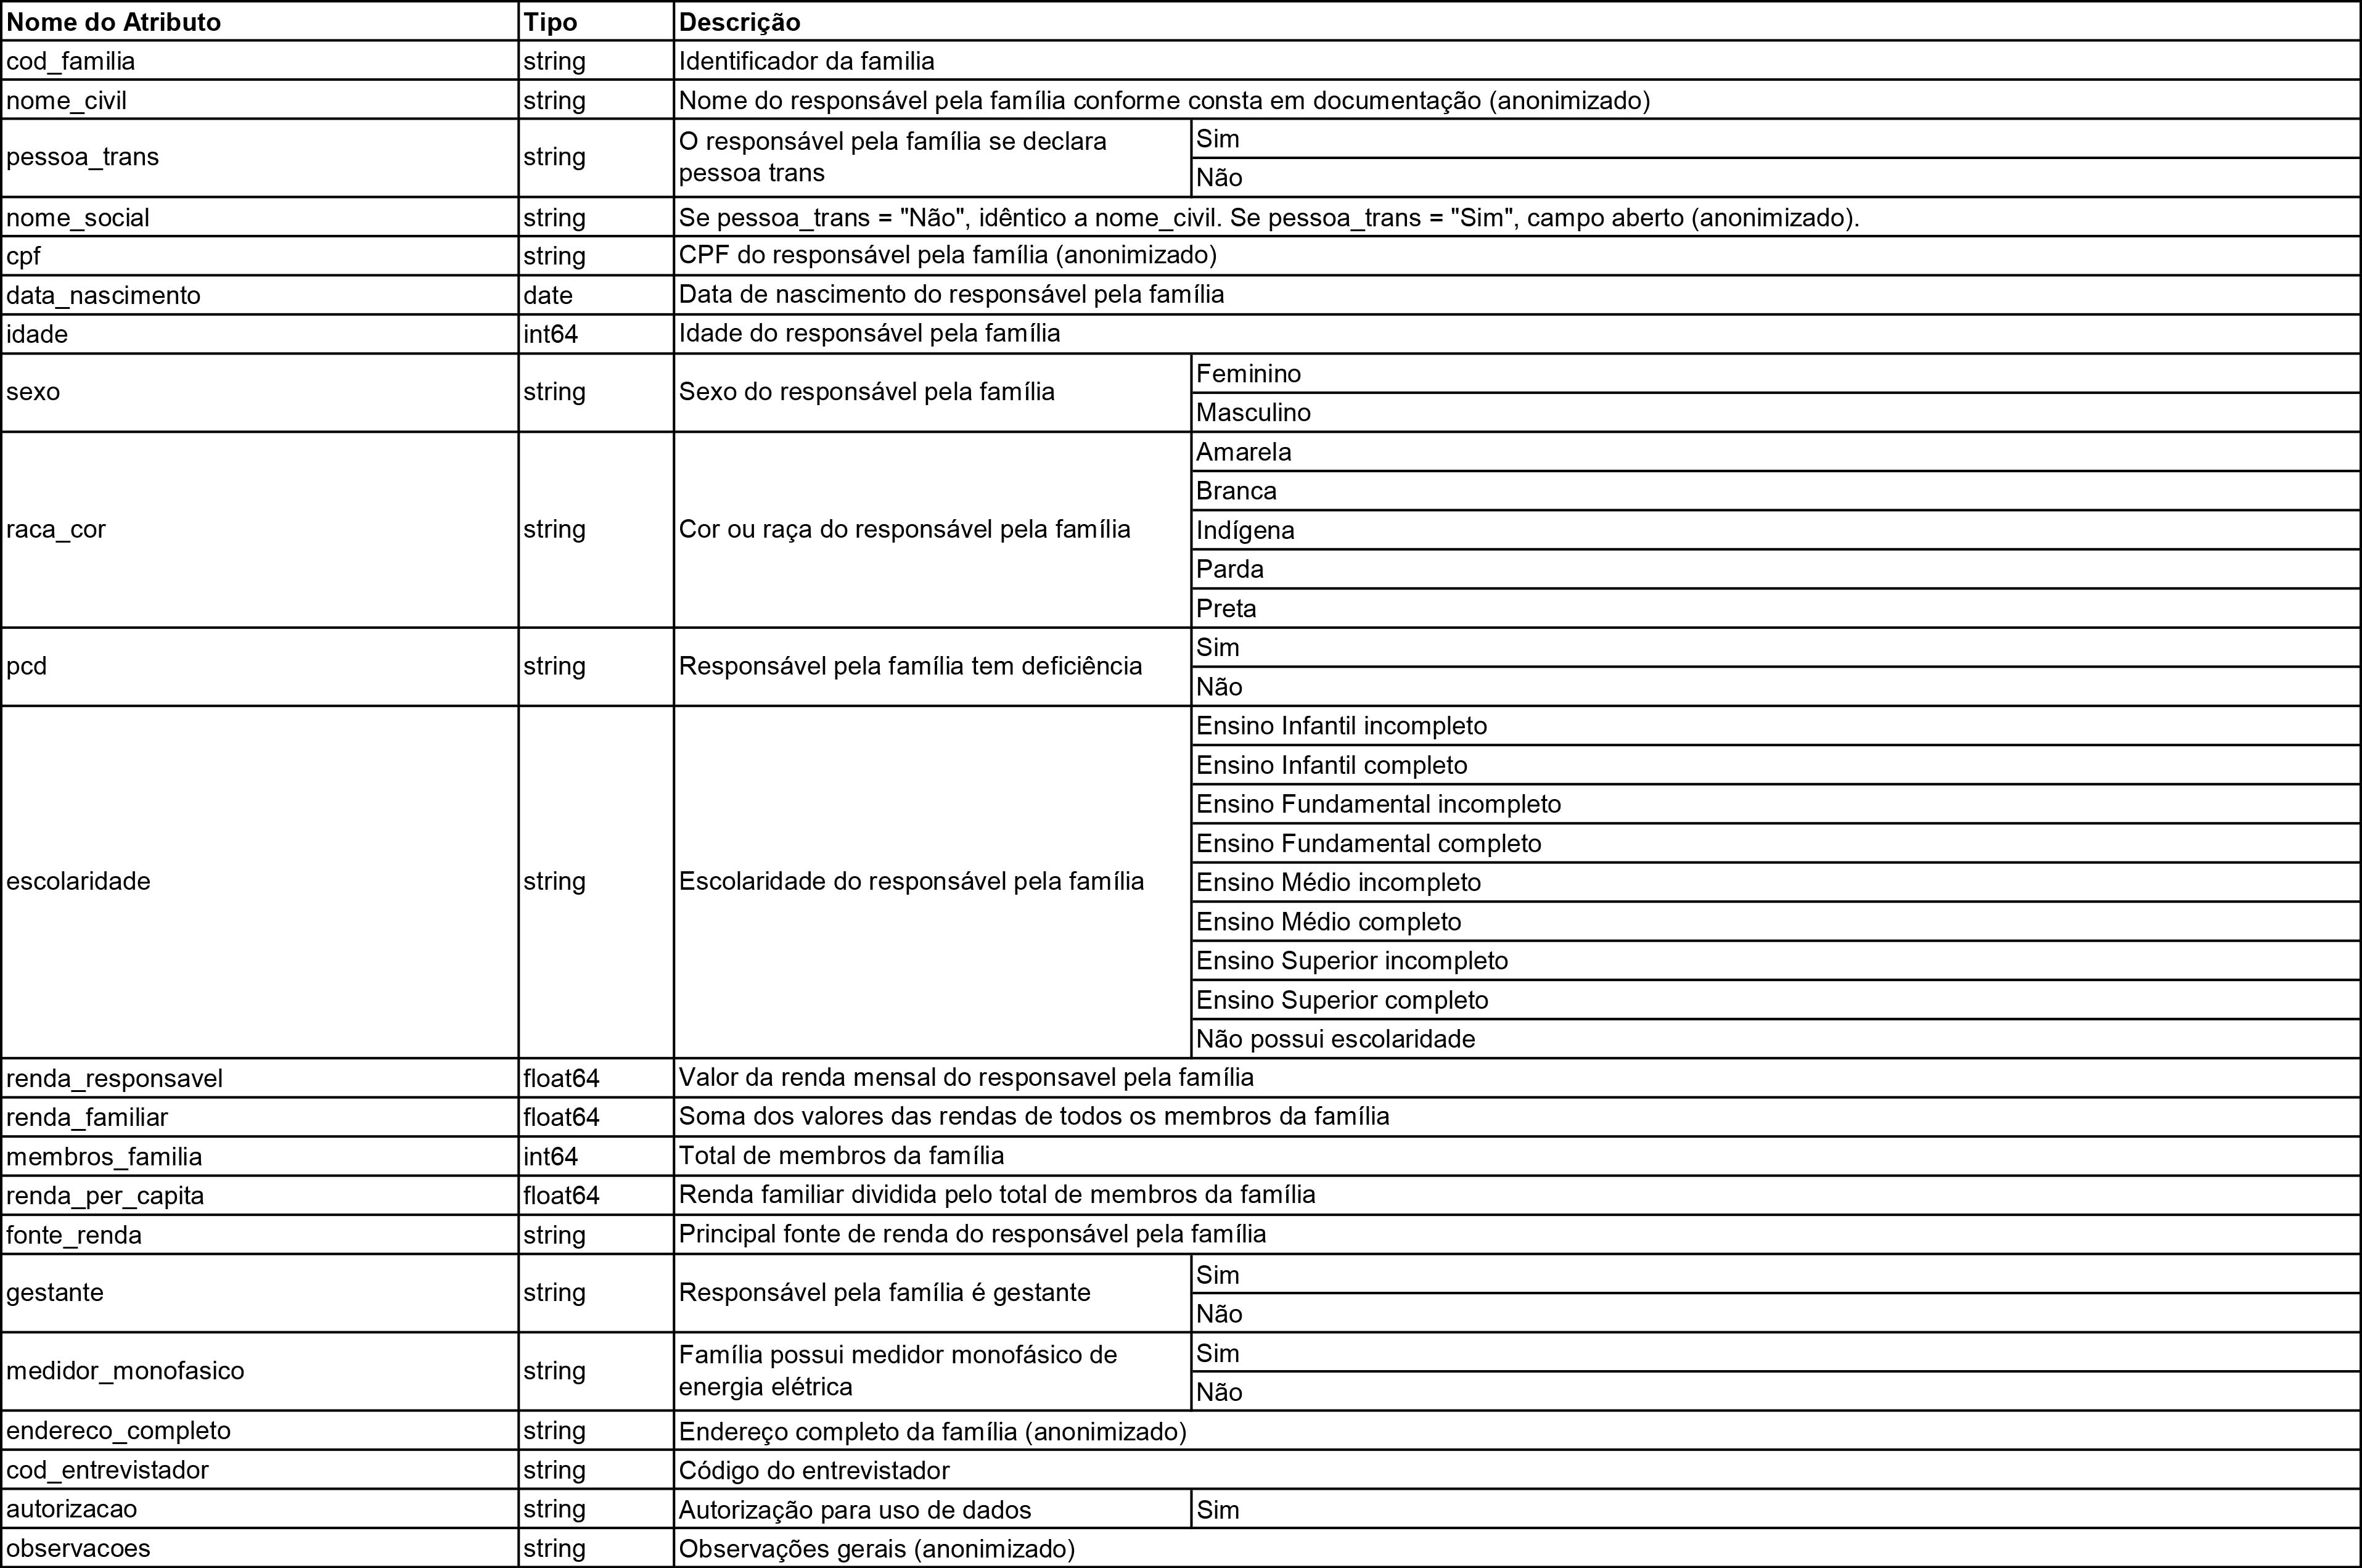

#Criando a camada Silver

In [362]:
df_acao_silver = df_acao_bronze.copy()

#Fazendo uma análise estatística da camada Silver antes da limpeza de dados

In [363]:
#Calculando o describe
tabela = df_acao_silver.describe()

#Aplicando formatação no padrão brasileiro
for col in tabela.columns:
    tabela[col] = tabela[col].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

#Exibindo
print(tabela)


          idade renda_responsavel renda_familiar membros_familia  \
count  6.529,00          6.525,00       6.530,00        6.530,00   
mean      45,95            433,79         479,68            1,62   
std       26,99            564,49         631,76            1,10   
min       16,00              0,00           0,00            1,00   
25%       33,00              0,00           0,00            1,00   
50%       44,00            200,00         200,00            1,00   
75%       57,00            600,00         670,00            2,00   
max      974,00          5.400,00       6.300,00           19,00   

      renda_per_capita  
count         6.530,00  
mean            335,23  
std             468,21  
min               0,00  
25%               0,00  
50%             150,00  
75%             500,00  
max           4.500,00  


#Fazendo a limpeza de dados na camada Silver

In [364]:
#Verificando se há registros sem cod_familia
qtd = df_acao_silver['cod_familia'].isna().sum()
print(f"Quantidade de registros sem cod_familia: {qtd:,}".replace(",", "."))

Quantidade de registros sem cod_familia: 0


In [365]:
#Verificando se há registros sem data_nascimento
qtd = df_acao_silver['data_nascimento'].isna().sum()
print(f"Quantidade de registros sem data_nascimento: {qtd:,}".replace(",", "."))

Quantidade de registros sem data_nascimento: 1


In [366]:
#Removendo o registro sem data de nascimento
df_acao_silver = df_acao_silver.dropna(subset=["data_nascimento"])

#Conferindo
qtd = df_acao_silver['data_nascimento'].isna().sum()
print(f"Quantidade de registros sem data_nascimento: {qtd:,}".replace(",", "."))

Quantidade de registros sem data_nascimento: 0


In [367]:
#Verificando se há registros sem idade
qtd = df_acao_silver['idade'].isna().sum()
print(f"Quantidade de registros sem idade: {qtd:,}".replace(",", "."))

Quantidade de registros sem idade: 0


In [368]:
#Verificando se há idades atípicas
df_acao_silver['idade'].value_counts(dropna=False).sort_index()

idade
16.0     12
17.0     20
18.0     57
19.0     44
20.0     58
         ..
160.0     1
356.0     1
834.0     1
913.0     2
974.0     1
Name: count, Length: 89, dtype: int64

Aqui há obviamente uma considerável quantidade de idades atípicas. Como a idade máximo do DataFrame do MDS foi 130 anos, usarei o mesmo parâmetro aqui.


In [369]:
#Retirando idades maiores que 130 anos
df_acao_silver = df_acao_silver[df_acao_silver["idade"] <= 130]

#Conferindo

#Verificando se há idades atípicas
df_acao_silver['idade'].value_counts(dropna=False).sort_index()


idade
16.0     12
17.0     20
18.0     57
19.0     44
20.0     58
         ..
94.0      1
95.0      2
107.0     1
124.0     1
125.0     2
Name: count, Length: 81, dtype: int64

In [370]:
#Verificando se há registros sem sexo
qtd = df_acao_silver['sexo'].isna().sum()
print(f"Quantidade de registros sem sexo: {qtd:,}".replace(",", "."))

Quantidade de registros sem sexo: 0


In [371]:
#Verificando se há registros sem raca_cor
qtd = df_acao_silver['raca_cor'].isna().sum()
print(f"Quantidade de registros sem raca_cor: {qtd:,}".replace(",", "."))

Quantidade de registros sem raca_cor: 52


In [372]:
#Substituindo NaN em raca_cor por "Não informado"
df_acao_silver.loc[:,'raca_cor'] = df_acao_silver['raca_cor'].fillna("Não informado")

#Conferindo
qtd = df_acao_silver['raca_cor'].isna().sum()
print(f"Quantidade de registros sem raca_cor: {qtd:,}".replace(",", "."))

Quantidade de registros sem raca_cor: 0


In [373]:
#Verificando se há registros sem pcd
qtd = df_acao_silver['pcd'].isna().sum()
print(f"Quantidade de registros sem pcd: {qtd:,}".replace(",", "."))

Quantidade de registros sem pcd: 0


In [374]:
#Verificando se há registros sem escolaridade
qtd = df_acao_silver['escolaridade'].isna().sum()
print(f"Quantidade de registros sem escolaridade: {qtd:,}".replace(",", "."))

Quantidade de registros sem escolaridade: 644


In [375]:
#Substituindo NaN em escolaridade por "Não informado"
df_acao_silver.loc[:,'escolaridade'] = df_acao_silver['escolaridade'].fillna("Não informado")

#Conferindo
qtd = df_acao_silver['escolaridade'].isna().sum()
print(f"Quantidade de registros sem escolaridade: {qtd:,}".replace(",", "."))

Quantidade de registros sem escolaridade: 0


In [376]:
#Verificando se há registros sem renda_responsavel
qtd = df_acao_silver['renda_responsavel'].isna().sum()
print(f"Quantidade de registros sem renda_responsavel: {qtd:,}".replace(",", "."))

Quantidade de registros sem renda_responsavel: 4


In [377]:
#Substituindo NaN em renda_responsavel por 0
df_acao_silver.loc[:,'renda_responsavel'] = df_acao_silver['renda_responsavel'].fillna(0)

#Conferindo
qtd = df_acao_silver['renda_responsavel'].isna().sum()
print(f"Quantidade de registros sem renda_responsavel: {qtd:,}".replace(",", "."))

Quantidade de registros sem renda_responsavel: 0


In [378]:
#Verificando se há registros sem renda_familiar
qtd = df_acao_silver['renda_familiar'].isna().sum()
print(f"Quantidade de registros sem renda_familiar: {qtd:,}".replace(",", "."))

Quantidade de registros sem renda_familiar: 0


In [379]:
#Verificando se há registros sem renda_per_capita
qtd = df_acao_silver['renda_per_capita'].isna().sum()
print(f"Quantidade de registros sem renda_per_capita: {qtd:,}".replace(",", "."))


Quantidade de registros sem renda_per_capita: 0


Vamos, agora, aplicar as condições para inscrição no CadÚnico.

In [380]:
#Criando o filtro
filtro = (
    (df_acao_silver["renda_per_capita"] <= 706) |
    (df_acao_silver["renda_familiar"] <= 4236) |
    (df_acao_silver["pcd"] == "Sim") |
    (df_acao_silver["renda_per_capita"].isna()) |
    (df_acao_silver["renda_familiar"].isna()) |
    (df_acao_silver["renda_per_capita"] == 0) |
    (df_acao_silver["renda_familiar"] == 0)
)

#Aplicando o filtro
df_acao_silver = df_acao_silver[filtro].copy()

df_acao_silver


cod_familia                                  nome_civil  \
1     2025-03-25-R-4822                  ##########################   
2     2025-06-26-R-7914          ##################################   
3     2025-05-31-R-2464             ###############################   
5     2024-06-22-R-5631           #################################   
6     2025-02-12-R-1130           #################################   
...                 ...                                         ...   
6524  2025-07-05-R-6245             ###############################   
6525  2023-10-31-R-6242               #############################   
6526  2023-10-31-R-6637  ##########################################   
6527  2023-11-03-R-6303                   #########################   
6528  2023-11-03-R-2970     #######################################   

     pessoa_trans                                 nome_social          cpf  \
1             Não                  ##########################  ###########   
2             Não          ##################################  ###########   
3             Não             ###############################  ###########   
5             Não           #################################  ###########   
6             Não           #################################  ###########   
...           ...                                         ...          ...   
6524          Não             ###############################  ###########   
6525          Não               #############################  ###########   
6526          Não  ##########################################  ###########   
6527          Não                   #########################  ###########   
6528          Não     #######################################  ###########   

     data_nascimento  idade       sexo raca_cor  pcd  ... renda_familiar  \
1         1988-08-09   36.0   Feminino    Parda  Não  ...           4000   
2         1978-03-06   47.0  Masculino   Branca  Não  ...           4000   
3         1978-09-19   46.0   Feminino    Parda  Não  ...           3300   
5         1985-11-14   39.0   Feminino    Parda  Não  ...           3000   
6         1980-10-19   44.0   Feminino    Parda  Não  ...           3000   
...              ...    ...        ...      ...  ...  ...            ...   
6524      1990-09-17   34.0   Feminino    Parda  Não  ...              0   
6525      1988-05-23   37.0   Feminino    Parda  Não  ...              0   
6526      2000-10-10   24.0   Feminino    Parda  Não  ...              0   
6527      1988-05-23   37.0  Masculino   Branca  Não  ...              0   
6528      1988-05-23   37.0   Feminino    Parda  Não  ...              0   

      membros_familia  renda_per_capita      fonte_renda  gestante  \
1                   1            4000.0  Trabalho Formal       Não   
2                   1            4000.0            Bicos       Não   
3                   1            3300.0  Trabalho Formal       Não   
5                   1            3000.0      Outra Fonte       Não   
6                   1            3000.0  Trabalho Formal       Sim   
...               ...               ...              ...       ...   
6524                1               0.0       Não possui       Não   
6525                1               0.0              NaN       NaN   
6526                2               0.0              NaN       NaN   
6527                1               0.0              NaN       NaN   
6528                2               0.0              NaN       NaN   

     medidor_monofasico                                  endereco_completo  \
1                   Sim                                                NaN   
2                   Sim  ##############################################...   
3                   Não  ##############################################...   
5                   Não  ##############################################...   
6                   Sim                            #######################   


#Fazendo uma análise estatística da camada Silver depois da limpeza de dados

In [381]:
desc = df_acao_silver.describe()

for col in desc.columns:
    desc[col] = desc[col].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

print(desc)

          idade renda_responsavel renda_familiar membros_familia  \
count  6.511,00          6.511,00       6.511,00        6.511,00   
mean      45,32            430,09         473,63            1,62   
std       15,79            553,52         610,00            1,10   
min       16,00              0,00           0,00            1,00   
25%       33,00              0,00           0,00            1,00   
50%       44,00            200,00         200,00            1,00   
75%       56,00            600,00         650,00            2,00   
max      125,00          4.000,00       4.000,00           19,00   

      renda_per_capita  
count         6.511,00  
mean            332,74  
std             462,19  
min               0,00  
25%               0,00  
50%             150,00  
75%             500,00  
max           4.000,00  


#Comparando os DataFrames

Finalmente estamos prontos para compararmos os dados dos DataFrame provenientes do Ministério do Desenvolvimento e Assistência Social, Família e Combate à Fome (MDS) com aqueles provenientes do projeto Busca Ativa (BA).

##Analisando as idades

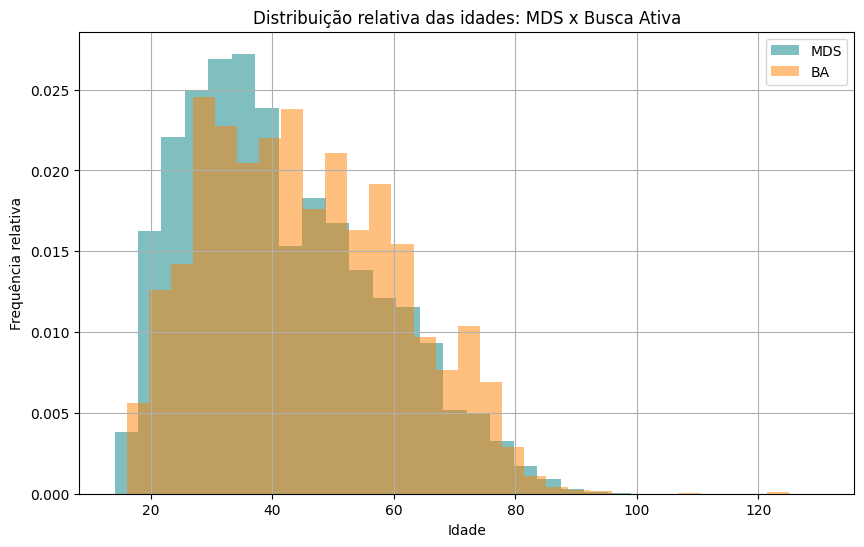

In [382]:
plt.figure(figsize=(10,6))

plt.hist(df_mds_gold["idade"], bins=30, alpha=0.5, label="MDS", color='#008080', density=True)
plt.hist(df_acao_silver["idade"], bins=30, alpha=0.5, label="BA", color='#FF8000', density=True)

plt.xlabel("Idade")
plt.ylabel("Frequência relativa")
plt.title("Distribuição relativa das idades: MDS x Busca Ativa")
plt.legend()
plt.grid(True)
plt.show()



Aqui, podemos perceber que o projeto Busca Ativa tende a entrevistar pessoas um pouco mais velhas do que aquelas que já estão cadastradas no CadÚnico.

Vamos montar uma tabela comparativa entre as estatísticas sobre as idades dos dois DataFrames.

In [383]:
#Obtendo as estatísticas
stats_mds = df_mds_gold["idade"].describe()
stats_acao = df_acao_silver["idade"].describe()

#Criando a tabela
tabela_comparativa = pd.concat([stats_mds, stats_acao], axis=1)
tabela_comparativa.columns = ["MDS", "BA"]

#Formatando cada coluna da tabela
tabela_formatada = tabela_comparativa.copy()

for col in tabela_formatada.columns:
    tabela_formatada[col] = tabela_formatada[col].map(
        lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    )

#Exibindo a tabela
print(tabela_formatada)

              MDS        BA
count  372.549,00  6.511,00
mean        41,50     45,32
std         15,69     15,79
min         14,00     16,00
25%         29,00     33,00
50%         39,00     44,00
75%         52,00     56,00
max        130,00    125,00


##Analisando os tamanhos das famílias

<Figure size 1000x600 with 0 Axes>

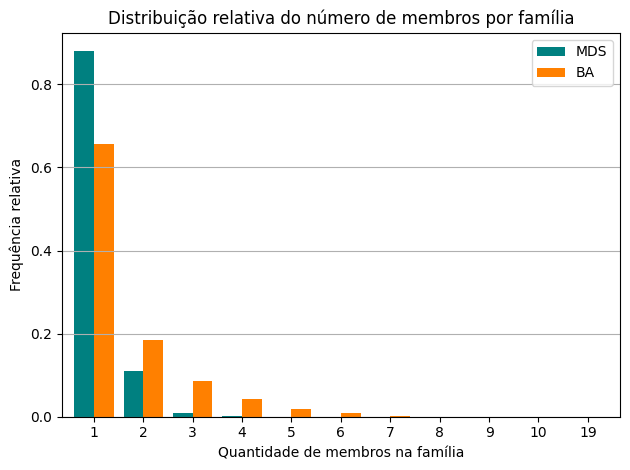

In [384]:
#Frequência relativa de qtd_membros nos dois dataframes
freq_mds = df_mds_gold["qtd_membros"].value_counts(normalize=True).sort_index()
freq_acao = df_acao_silver["membros_familia"].value_counts(normalize=True).sort_index()

#Juntando os dois em um DataFrame para facilitar o plot
df_freq = pandas.concat([freq_mds, freq_acao], axis=1)
df_freq.columns = ["MDS", "BA"]
df_freq = df_freq.fillna(0)

#Criando o Gráfico de barras
plt.figure(figsize=(10,6))
df_freq.plot(kind="bar", width=0.8, color=["#008080", "#FF8000"])

plt.xlabel("Quantidade de membros na família")
plt.ylabel("Frequência relativa")
plt.title("Distribuição relativa do número de membros por família")
plt.xticks(rotation=0)
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


Aqui, percebemos que em ambos os DataFrames, a quantidade de famílias unipessoais é significativamente maior. Além disso, percebemos que os entrevistados pelo projeto Busca Ativa tendem a ter famílias maiores que aqueles cadastrados no CadÚnico.

Vamos montar uma tabela comparativa entre as estatísticas sobre os tamanhos das famílias nos dois DataFrames.

In [385]:
#Calculando estatísticas descritivas
desc_mds = df_mds_gold["qtd_membros"].describe()
desc_ba = df_acao_silver["membros_familia"].describe()

#Juntando
tabela_comparativa = pandas.concat([desc_mds, desc_ba], axis=1)
tabela_comparativa.columns = ["MDS", "BA"]

#Formatando no padrão brasileiro
for col in tabela_comparativa.columns:
    tabela_comparativa[col] = tabela_comparativa[col].map(
        lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    )

#Exibindo a tabela
print(tabela_comparativa)


              MDS        BA
count  372.549,00  6.511,00
mean         1,13      1,62
std          0,37      1,10
min          1,00      1,00
25%          1,00      1,00
50%          1,00      1,00
75%          1,00      2,00
max          6,00     19,00


Aqui, para nossa surpresa, percebemos que o 3o quartil ainda é 2. Ou seja, famílias numerosas de baixa renda não são a regra.

##Analisando os sexos

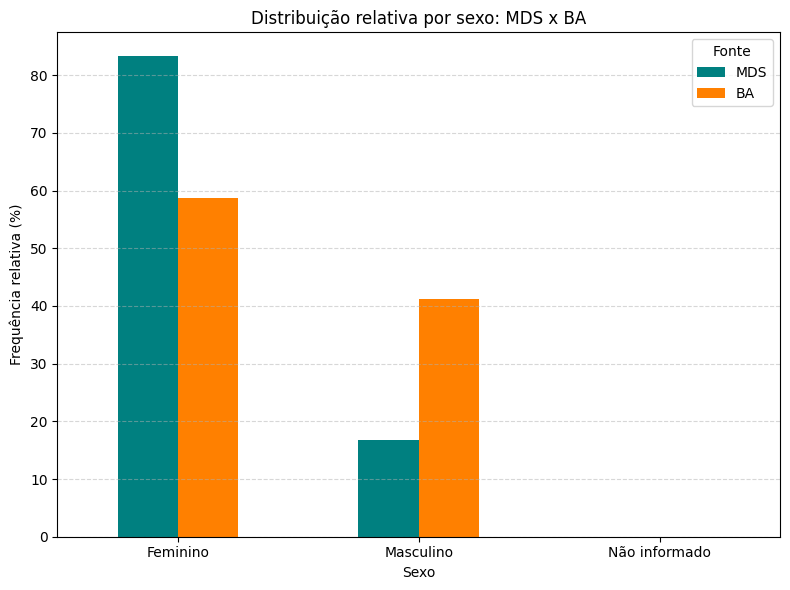

In [386]:
#Calculando as proporções (%)
sexo_mds = df_mds_gold["sexo"].value_counts(normalize=True) * 100
sexo_ba = df_acao_silver["sexo"].value_counts(normalize=True) * 100

#Juntando os dois em um DataFrame
df_sexo = pandas.concat([sexo_mds, sexo_ba], axis=1)
df_sexo.columns = ["MDS", "BA"]
df_sexo = df_sexo.fillna(0)  # Caso haja categorias ausentes

#Ordenando as categorias para manter consistência visual
df_sexo = df_sexo.reindex(["Feminino", "Masculino", "Não informado"])

#Criando o gráfico de barras
ax = df_sexo.plot(kind="bar", figsize=(8,6), color=["#008080", "#FF8000"])

plt.title("Distribuição relativa por sexo: MDS x BA")
plt.xlabel("Sexo")
plt.ylabel("Frequência relativa (%)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Fonte")
plt.tight_layout()
plt.show()


Aqui, uma discrepância significativa. Apesar de as duas bases de dados mostrarem a predominância do sexo feminino, o projeto Busca Ativa entrevistou mais homens no cômputo geral quando comparado ao CadÚnico.

##Analisando as raças e as cores

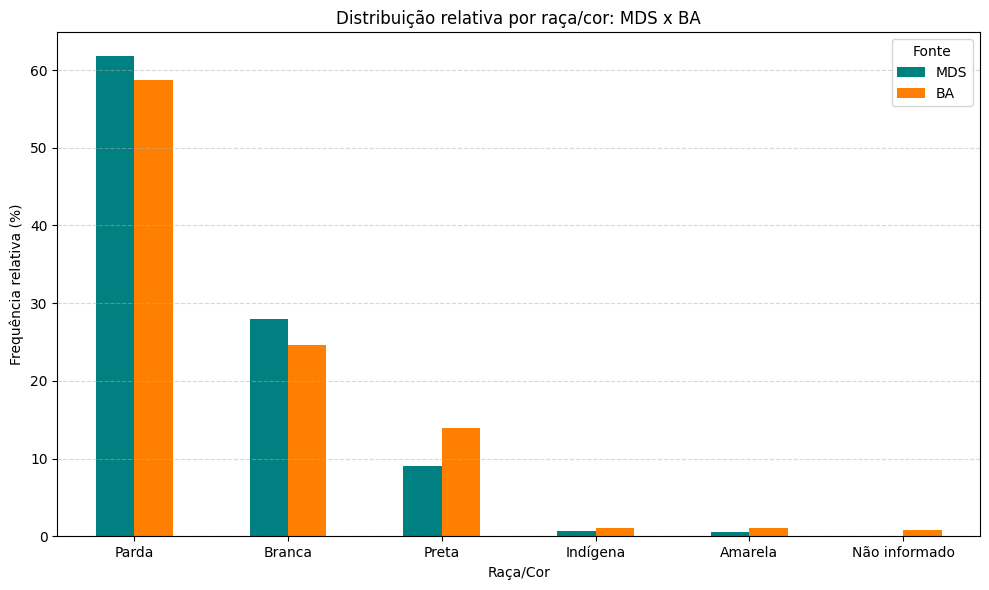

In [387]:
#Calculando a frequência relativa (%)
raca_mds = df_mds_gold["raca_cor"].value_counts(normalize=True) * 100
raca_ba = df_acao_silver["raca_cor"].value_counts(normalize=True) * 100

#Juntando os dois DataFrames
df_raca = pandas.concat([raca_mds, raca_ba], axis=1)
df_raca.columns = ["MDS", "BA"]
df_raca = df_raca.fillna(0)

#Reorganizando para manter a ordem conhecida
ordem = ["Parda", "Branca", "Preta", "Indígena", "Amarela", "Não informado"]
df_raca = df_raca.reindex(ordem)

#Plotando
ax = df_raca.plot(kind="bar", figsize=(10,6), color=["#008080", "#FF8000"])

ax.set_title("Distribuição relativa por raça/cor: MDS x BA")
ax.set_xlabel("Raça/Cor")
ax.set_ylabel("Frequência relativa (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(title="Fonte")
plt.tight_layout()
plt.show()


Até agora, esse foi o atributo do projeto Busca Ativa mais consistente com os dados do CadÚnico, com uma leve tendência a entrevistar mais pessoas pretas no projeto.

##Analisando as escolaridades

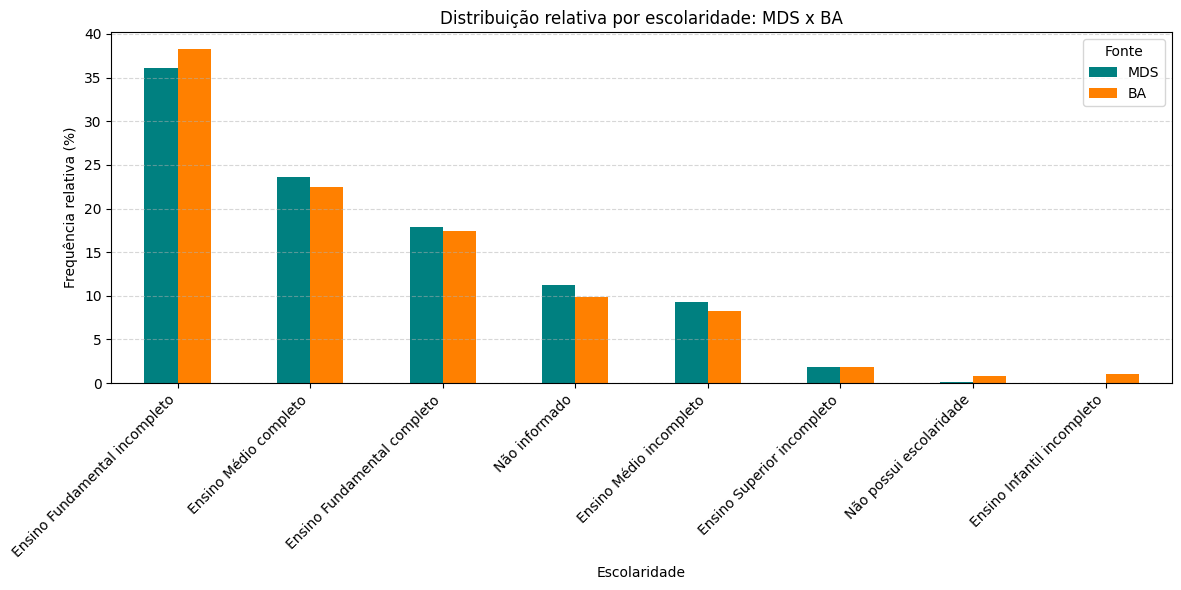

In [388]:
# Frequência relativa (%)
esc_mds = df_mds_gold["escolaridade"].value_counts(normalize=True) * 100
esc_ba  = df_acao_silver["escolaridade"].value_counts(normalize=True) * 100

# Junta os dois em um DataFrame
df_esc = pandas.concat([esc_mds, esc_ba], axis=1)
df_esc.columns = ["MDS", "BA"]
df_esc = df_esc.fillna(0)

# Ordena por ordem lógica ou mais frequente
ordem = [
    "Ensino Fundamental incompleto",
    "Ensino Médio completo",
    "Ensino Fundamental completo",
    "Não informado",
    "Ensino Médio incompleto",
    "Ensino Superior incompleto",
    "Não possui escolaridade",
    "Ensino Infantil incompleto"
]
df_esc = df_esc.reindex(ordem)

# Gráfico de barras lado a lado
ax = df_esc.plot(kind="bar", figsize=(12,6), color=["#008080", "#FF8000"])

ax.set_title("Distribuição relativa por escolaridade: MDS x BA")
ax.set_xlabel("Escolaridade")
ax.set_ylabel("Frequência relativa (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(title="Fonte")
plt.tight_layout()
plt.show()


Aqui temos outro atributo consistente com os dados do CadÚnico. Os únicos pontos de atenção são a predominância de pouca escolaridade entre os entrevistados do projeto Busca Ativa.

##Analisando as rendas per capita

<Figure size 640x480 with 0 Axes>

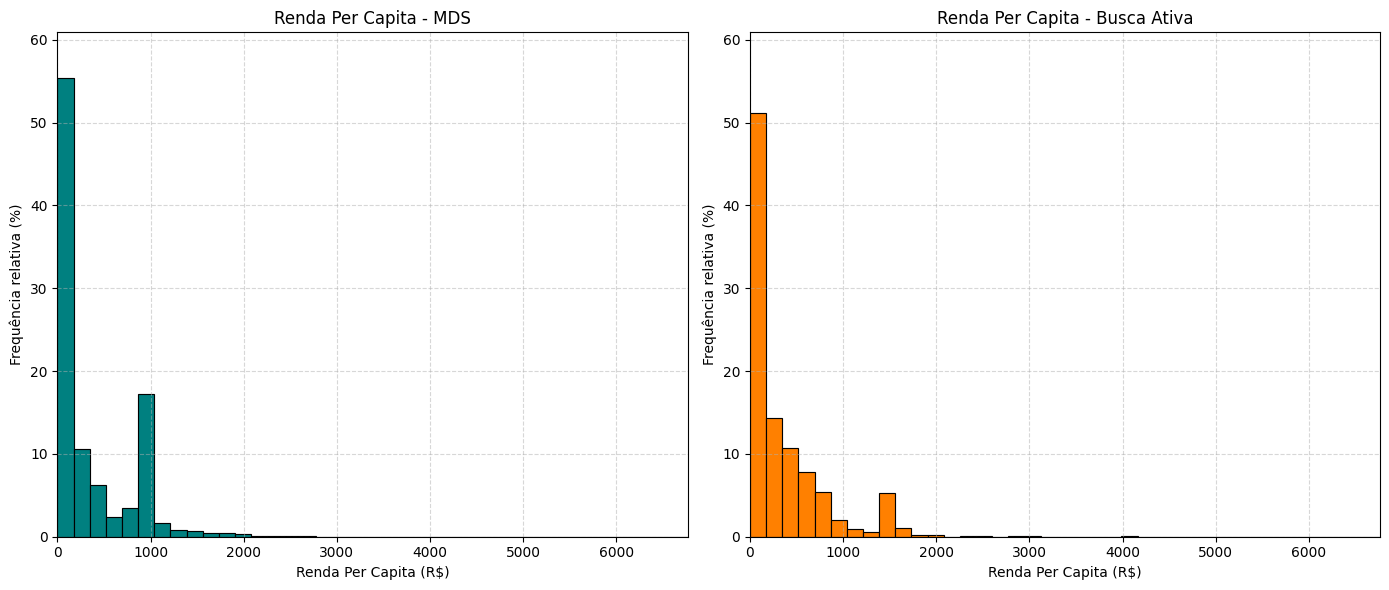

In [389]:
# Define o intervalo dos dados para o eixo X (maior e menor entre os dois datasets)
x_min = min(df_mds_gold["renda_per_capita"].min(), df_acao_silver["renda_per_capita"].min())
x_max = max(df_mds_gold["renda_per_capita"].max(), df_acao_silver["renda_per_capita"].max())

# Cria bins uniformes entre min e max
bins = np.linspace(x_min, x_max, 40)

# Captura as alturas dos bins para cada dataset (plot invisível)
fig, ax = plt.subplots()
hist_mds = sns.histplot(df_mds_gold["renda_per_capita"], bins=bins, stat="percent", kde=False)
heights_mds = [patch.get_height() for patch in hist_mds.patches]
plt.clf()

hist_ba = sns.histplot(df_acao_silver["renda_per_capita"], bins=bins, stat="percent", kde=False)
heights_ba = [patch.get_height() for patch in hist_ba.patches]
plt.clf()

# Define o limite máximo do eixo Y com 10% de margem
y_max = max(max(heights_mds), max(heights_ba)) * 1.1

# Plot final com eixos X e Y alinhados
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(df_mds_gold["renda_per_capita"], bins=bins, stat="percent", kde=False, color="#008080", alpha=1.0)
plt.title("Renda Per Capita - MDS")
plt.xlabel("Renda Per Capita (R$)")
plt.ylabel("Frequência relativa (%)")
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(1, 2, 2)
sns.histplot(df_acao_silver["renda_per_capita"], bins=bins, stat="percent", kde=False, color="#FF8000", alpha=1.0)
plt.title("Renda Per Capita - Busca Ativa")
plt.xlabel("Renda Per Capita (R$)")
plt.ylabel("Frequência relativa (%)")
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


Os histogramas de renda per capita contam histórias bem semelhantes, com apenas alguns detalhes divergentes. Em ambos, a frequência, como era de se esperar, é maior em valores muito baixos. No caso dos inscritos no CadÚnico há uma quantidade significativamente maior de pessoas quase sem renda.

Ainda em relação a esses registros, há um curioso pico próximo de R\$ 1.000,00, talvez referindo-se a famílias com uma ou duas pessoas sustentadas por um salário mínimo.

No caso dos entrevistados pelo projeto Busca Ativa, tal pico se localiza próximo a R\$ 1.500,00.